In [1]:
%load_ext autoreload
%autoreload 2
from tdf_pool.race import Race
from tdf_pool.cycling_calendar import get_calendar
from tdf_pool.score import get_score_template, score_race
from tdf_pool.custom_stats import custom_f_score
from datetime import date
import logging
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import pairwise
from sklearn.metrics import mean_absolute_error, mean_squared_error

logging.basicConfig(level="INFO")

In [2]:
years = list(range(2014, 2024))
tdf_races = []
for year in years:
    calendar = get_calendar(year)
    tdf_entry = calendar[calendar['Name'] == "Tour de France"].iloc[0]
    tdf = Race(tdf_entry['Name'], tdf_entry['Start'], tdf_entry['Type'], tdf_entry['PartialURL'])
    tdf_races.append(tdf)

INFO:tdf_pool.cycling_calendar:[ OK ] Read race calender of 2014
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 1, Leeds - Harrogate, Date: 2014-07-05, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 2, York - Sheffield, Date: 2014-07-06, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 3, Cambridge - London, Date: 2014-07-07, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 4, Le Touquet Paris-Plage - Lille, Date: 2014-07-08, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 5, Ypres - Arenberg Porte du Hainaut, Date: 2014-07-09, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 6, Arras - Reims, Date: 2014-07-10, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 7, Epernay - Nancy, Date: 2014-07-11, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France sta

In [3]:
score_template = get_score_template()
tdf_scores = [score_race(race, score_template) for race in tdf_races]

INFO:tdf_pool.score:Scoring <Tour de France stage 1, Leeds - Harrogate, Date: 2014-07-05, Type: Stage>
INFO:tdf_pool.score:Scoring <Tour de France stage 2, York - Sheffield, Date: 2014-07-06, Type: Stage>
INFO:tdf_pool.score:Scoring <Tour de France stage 3, Cambridge - London, Date: 2014-07-07, Type: Stage>
INFO:tdf_pool.score:Scoring <Tour de France stage 4, Le Touquet Paris-Plage - Lille, Date: 2014-07-08, Type: Stage>
INFO:tdf_pool.score:Scoring <Tour de France stage 5, Ypres - Arenberg Porte du Hainaut, Date: 2014-07-09, Type: Stage>
INFO:tdf_pool.score:Scoring <Tour de France stage 6, Arras - Reims, Date: 2014-07-10, Type: Stage>
INFO:tdf_pool.score:Scoring <Tour de France stage 7, Epernay - Nancy, Date: 2014-07-11, Type: Stage>
INFO:tdf_pool.score:Scoring <Tour de France stage 8, Tomblaine - Gerardmer, Date: 2014-07-12, Type: Stage>
INFO:tdf_pool.score:Scoring <Tour de France stage 9, Gerardmer - Mulhouse, Date: 2014-07-13, Type: Stage>
INFO:tdf_pool.score:Scoring <Tour de France

In [4]:
stat = "Total"
all_comparisons = []
for (previous_year, previous_tdf, previous_scores), (this_year, this_tdf, this_scores) in pairwise(zip(years, tdf_races, tdf_scores)):
    prediction = previous_scores.set_index("Rider")[[stat]]
    actual = this_scores.set_index("Rider")[[stat]]

    comparison = actual.join(prediction, how='left', rsuffix='_pred')
    comparison = comparison.fillna(prediction[stat].mean())
    all_comparisons.append(comparison)
    print(custom_f_score(comparison[stat].values, comparison[stat+'_pred'].values))


all_comparisons = pd.concat(all_comparisons)
print("MAE: ", mean_absolute_error(all_comparisons[stat], all_comparisons[stat+"_pred"]))
print("sqrt(MSE): ", np.sqrt(mean_squared_error(all_comparisons[stat], all_comparisons[stat+"_pred"])))

0.4666666666666667
0.4666666666666667
0.5333333333333333
0.3333333333333333
0.4666666666666667
0.3333333333333333
0.26666666666666666
0.3870967741935484
0.4666666666666667
MAE:  67.36567304668652
sqrt(MSE):  101.54003716465613


Text(0, 0.5, 'pred')

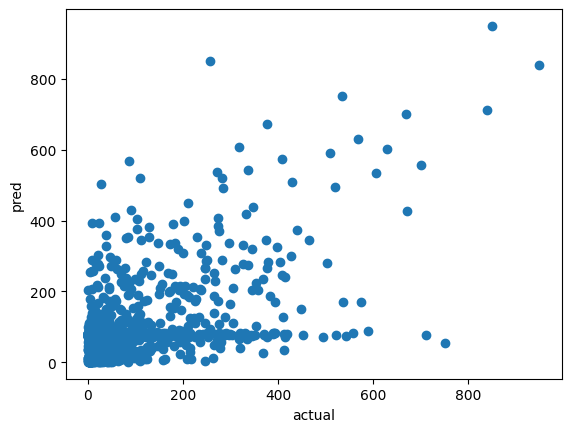

In [5]:
plt.scatter(all_comparisons[stat], all_comparisons[stat+"_pred"])
plt.xlabel("actual")
plt.ylabel("pred")